# Stanford Dogs Classification Dataset

### Summary :
##### - Images have been cropped, rescaled and resized for training.
##### - Images have been loaded through image generator at batch size of 32.
##### - I have used InceptionV3 and EfficientNetV2B0 for training. Both models were chosen keeping efficiency as priority.
##### - InceptionV3, at 86.5% validation accuracy and 79.0% testing accuracy has performed better than EfficientNetV2B0 at 78.0% validation accuracy and 64% testing accuracy.
##### - InceptionV3 was run with non trainable original layers with extra layers added, while EfficientNetV2B0 was run with trainable original layers as well as extra layers.  
##### - Model performance can be improved with increased epochs and adjustment of number of layers and learning rate. 

### Mounting drive to shift tar files to colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing libraries and files 

In [29]:
import tarfile
import os
import shutil
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback,ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

from keras.optimizers import Adam
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.layers import Lambda, Input, GlobalAveragePooling2D,BatchNormalization

from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetV2B0
from keras.src.applications.inception_v3 import InceptionV3

In [3]:
# Importing images folder
tar_file_path = ('/content/drive/MyDrive/images.tar')
destination_dir = ('/content')

In [4]:
with tarfile.open(tar_file_path, 'r') as tar:
    tar.extractall(path=destination_dir)

In [5]:
# Importing annotation folder 
tar_file_path2 = ("/content/drive/MyDrive/annotation.tar")
destination_dir2 = ('/content')

In [6]:
with tarfile.open(tar_file_path2, 'r') as tar:
    tar.extractall(path=destination_dir2)

In [7]:
del(tar_file_path,destination_dir,tar_file_path2,destination_dir2)

In [ ]:
-------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Creating Train, Test, Cropped folders & moving images

In [9]:
# Defining folders paths
main_folder  = '/content'
images_folder = "/content/Images"
train_folder = "/content/Train folder"
test_folder = "/content/Test folder"
Cropped_train = "/content/Cropped Train"


In [9]:
# Creating Train and Test folders 
os.makedirs(os.path.join(main_folder, "Train folder"))
os.makedirs(os.path.join(main_folder, "Test folder"))

In [10]:
breed_folder_list = [i for i in os.listdir("/content/Images")]

In [11]:
# Accessing subfolder paths and splitting list of images into train and test in 80:20 ratio
# Using Shutil to copy images into train and test folders 
for i in breed_folder_list:
    breed_folder_path = os.path.join(main_folder,images_folder, i)
    os.makedirs(os.path.join(train_folder, i), exist_ok = True)
    os.makedirs(os.path.join(test_folder, i), exist_ok = True)
    list_of_images = [j for j in os.listdir(breed_folder_path)]
    train_images, test_images = train_test_split( list_of_images, test_size = 0.2, random_state = 42)
    for z in train_images:
        shutil.move(os.path.join(breed_folder_path, z ), os.path.join(train_folder, i, z) )
    for z in test_images:
        shutil.move(os.path.join(breed_folder_path, z ), os.path.join(test_folder, i, z) )


In [12]:
# Copying train set to Cropped Train folder. This folder will be used to train model.
source_location = train_folder
destination_location = os.path.join(main_folder,"Cropped Train")
shutil.copytree(source_location,destination_location)

'/content/Cropped Train'

### Cropping images in the Cropped Train folder

In [13]:
# Function to get bounding boxes from annotation folder and crop images
def crop_and_overwrite(path, annotationpath):
    tree = ET.parse(annotationpath)
    xmin = int(tree.getroot().findall('.//xmin')[0].text)
    xmax = int(tree.getroot().findall('.//xmax')[0].text)
    ymin = int(tree.getroot().findall('.//ymin')[0].text)
    ymax = int(tree.getroot().findall('.//ymax')[0].text)
    image = Image.open(path)
    image = image.crop((xmin, ymin, xmax, ymax))
    image = image.convert('RGB')
    image.save(path)

In [14]:
# Function to apply cropping function defined above to Cropped Train folder
def apply_cropping( main_folder, Cropped_train):
    annotation_folder = "/content/Annotation"
    cropped_folder = os.path.join(main_folder, Cropped_train)
    cropped_folder_breeds= [i for i in os.listdir(cropped_folder)]
    for i in cropped_folder_breeds :
        cropped_folder_breeds_path = os.path.join(cropped_folder, i)
        for j in os.listdir(cropped_folder_breeds_path):
            path = os.path.join(cropped_folder_breeds_path,j)
            annotationpath = os.path.join(annotation_folder , i , os.path.splitext(j)[0])
            crop_and_overwrite(path, annotationpath)

In [15]:
apply_cropping( main_folder, Cropped_train)

### Displaying 5 samples of original image vs cropped image

In [16]:
Set1group = []
Set2group = []
sample_directory = os.listdir("/content/Train folder/n02091467-Norwegian_elkhound")
samples = sample_directory[:5]
for i in samples:
    Set1 = Image.open (os.path.join("/content/Train folder/n02091467-Norwegian_elkhound",i))
    Set2 = Image.open (os.path.join("/content/Cropped Train/n02091467-Norwegian_elkhound",i))
    Set1group.append(Set1)
    Set2group.append(Set2)

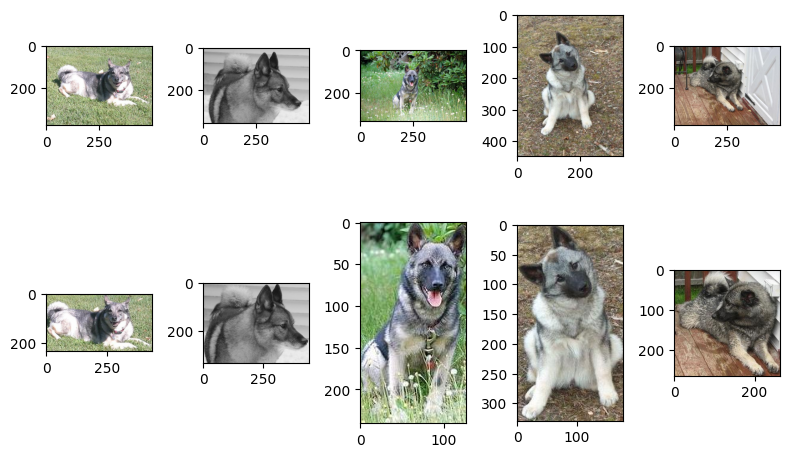

In [17]:
plt.figure(figsize = (8,5))

for i in range(5):
    plt.subplot(2,5,i+1)
    plt.imshow(Set1group[i])
    
    plt.subplot(2,5,i+6)
    plt.imshow(Set2group[i])

plt.tight_layout()
plt.show()

### Creating Train and Validation image generators 

In [10]:
data_source = Cropped_train

# Rescaling Images by dividing by 255
# Defining validation split 20%
Image_data_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)

# Defining target size 224x224 and batch size to load images
# Loading images batchwise is required to prevent computational overload
# Defining Class mode as categorical to encode labels 
train_generator = Image_data_generator.flow_from_directory(
    data_source,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training')

validation_generator = Image_data_generator.flow_from_directory(
    data_source,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation')


Found 13172 images belonging to 120 classes.
Found 3246 images belonging to 120 classes.


# 1) InceptionV3

### Creating a Base Model 

##### -Defined InceptionV3 with pre-trained Imagenet weights. 
##### -I am only using the Feature extractor of the Inception model.
##### -The original model trainable layers have been frozen.
##### -Multidimensional output will be passed into a pooling layer (average) and be converted into one dimension
##### -After normalization layer, output will be sent into a dense layer of 128 neurons
##### (I chose 512 neurons initially but the model was overfitting, and validation accuracy slightly improved after lowering the figure)
##### -Used Relu Activation because it is widely proven in Image classification sets and is very efficient.
##### -Output of dense layer will be sent through a dropout layer : disabling 50% to control overfitting. 
##### -Finally the output will be sent to a final dense layer of 120 neurons to be classified for highest probability using softmax for multiple breeds.

In [30]:
BaseModel = InceptionV3(input_shape = (224,224,3), weights = "imagenet", include_top = False)

for layer in BaseModel.layers:
    layer.trainable = False
X = BaseModel.output
X = GlobalAveragePooling2D()(X)
X = BatchNormalization()(X)
X = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(X)
X = Dropout(0.5)(X)
Denselayer = Dense(120, activation = "softmax")(X)
Model = Model(inputs = BaseModel.input, outputs= Denselayer)

### Optimizer

##### - Used a widely accepted starting learning rate of 0.001.
##### - Optimizer will be using 'accuracy' metric to measure training performance.
##### - Loss function is categorical_crossentropy for multiple breed classification

In [31]:
lr = 0.001
optimizer = Adam(lr)

Model.compile(
    loss = "categorical_crossentropy",
    optimizer = optimizer,
    metrics = ["accuracy"])

### Callbacks 
##### - Early stop to halt training if validation accuracy does not improve for 4 continous epochs. 
##### - LRR to decrease learning rate to 31.6% of current rate if validation accuracy does not improve for 3 continous epochs. 


In [32]:
earlyStop = [EarlyStopping(monitor='val_accuracy', patience = 4, restore_best_weights=True, verbose = 1) ]

reducelr = ReduceLROnPlateau(monitor='val_accuracy', factor=np.sqrt(.1), patience=3, verbose=1, min_lr=0.00001)

# Saving the best-performing model at a checkpoint to load later
checkpoint_filepath = r'C:\Users\91988\Documents\dog image classification\dogimmageclassification.keras'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True)

### Training 

In [33]:
# Running the model on 10 epochs
history = Model.fit(
train_generator,
validation_data = validation_generator,
callbacks = [earlyStop, reducelr, model_checkpoint],
epochs = 10,
batch_size = 32,
verbose = 1)

Epoch 1/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.5050 - loss: 2.5245
Epoch 1: val_accuracy improved from -inf to 0.83919, saving model to C:\Users\91988\Documents\dog image classification\dogimmageclassification.keras
412/412 ━━━━━━━━━━━━━━━━━━━━ 104s 201ms/step - accuracy: 0.5053 - loss: 2.5225 - val_accuracy: 0.8392 - val_loss: 0.7927 - learning_rate: 0.0010
Epoch 2/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7864 - loss: 1.0600
Epoch 2: val_accuracy did not improve from 0.83919
412/412 ━━━━━━━━━━━━━━━━━━━━ 64s 153ms/step - accuracy: 0.7864 - loss: 1.0600 - val_accuracy: 0.8380 - val_loss: 0.8172 - learning_rate: 0.0010
Epoch 3/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.8109 - loss: 0.9607
Epoch 3: val_accuracy improved from 0.83919 to 0.85613, saving model to C:\Users\91988\Documents\dog image classification\dogimmageclassification.keras
412/412 ━━━━━━━━━━━━━━━━━━━━ 106s 257ms/step - accuracy: 0.8109 - loss: 0.9607 - val_accuracy: 

##### - The model performs okay with a validation accuracy of 86.51% in the 10th epoch. 
##### - Validation accuracy is slightly lower than Training accuracy but the gap is small so it is acceptable.
##### - Loss values have gradually decreased with each epoch. 


### Training and Accuracy chart

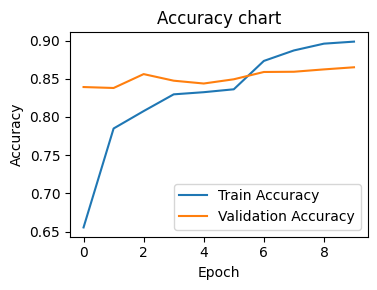

In [34]:
plt.figure(figsize=(7, 3))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy chart')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### Creating a test generator

In [35]:
from tensorflow.keras.models import load_model

# Load the best model saved by ModelCheckpoint
best_model_Inception = load_model(checkpoint_filepath)

In [36]:
# Loading Test images in batches of 32 via test generator to avoid computational issues 
# Rescaling Test images in the same manner as train images, and specifying the same dimensions.
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

Found 4162 images belonging to 120 classes.


### Test Predictions

In [37]:
# Generate predictions using the test generator
predictions = best_model_Inception.predict(test_generator, verbose=1)

131/131 ━━━━━━━━━━━━━━━━━━━━ 35s 208ms/step


In [38]:
# Get the predicted class index with the highest probability
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes

array([ 73,   0,   0, ..., 119, 117, 119])

In [39]:
len(predicted_classes)

4162

In [40]:
# Get the actual labels from the generator
true_classes = test_generator.classes
true_classes

array([  0,   0,   0, ..., 119, 119, 119], dtype=int32)

In [41]:
# Get the class labels mapping from the generator
class_labels = list(test_generator.class_indices.keys())
class_labels[:10]

['n02085620-Chihuahua',
 'n02085782-Japanese_spaniel',
 'n02085936-Maltese_dog',
 'n02086079-Pekinese',
 'n02086240-Shih-Tzu',
 'n02086646-Blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-Rhodesian_ridgeback',
 'n02088094-Afghan_hound']

In [42]:
# Compare the predicted and true classes
correct = np.sum(predicted_classes == true_classes)
incorrect = np.sum(predicted_classes != true_classes)

In [43]:
# Calculate accuracy
accuracy = correct / len(true_classes)

print(f"Correct predictions: {correct}")
print(f"Incorrect predictions: {incorrect}")
print(f"Accuracy: {accuracy:.2f}")

Correct predictions: 3304
Incorrect predictions: 858
Accuracy: 0.79


# 2) EfficientNet V2B0

### Creating the base model

##### -Smaller architecture than Inceptionv3. Just like InceptionV3, I chose this model for efficiency.
##### -Most parameters are same as running Inceptionv3 model, so same explanations are relevant.
##### -Same extra layer format used but I have allowed the original model layers to be trainable.
##### -Dense layers set at 512 because setting them at 256 resulted in model underfitting.
##### -Lowered dropout from 50% to 40% to allow better training than before with 512 neurons instead of 256 but also control overfitting.

In [5]:
BaseModel = EfficientNetV2B0(input_shape = (224,224,3), weights = "imagenet", include_top = False)

for layer in BaseModel.layers:
    layer.trainable = True
X = BaseModel.output
X = GlobalAveragePooling2D()(X)
X = BatchNormalization()(X)
X = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(X)
X = Dropout(0.4)(X)
Denselayer = Dense(120, activation = "softmax")(X)
Model = Model(inputs = BaseModel.input, outputs= Denselayer )

### Optimizer

##### - I used a widely accepted default learning rate.
##### - Optimizer will be using accuracy metric to measure training performance.
##### - Loss function is categorical_crossentropy for multiple breed classification

In [6]:
lr = 0.001
optimizer = Adam(lr)

Model.compile(
    loss = "categorical_crossentropy",
    optimizer = optimizer,
    metrics = ["accuracy"])

### Callbacks
##### - Early stop to halt training if validation accuracy does not improve for 3 continous epochs. 
##### - LRR to decrease learning rate by 31.6% of current rate if val accuracy does not improve for 2 continous epochs.

In [7]:
earlyStop = [EarlyStopping(monitor='val_accuracy', patience = 3, restore_best_weights=True, verbose = 1) ]

reducelr = ReduceLROnPlateau(monitor='val_accuracy', factor=np.sqrt(.1), patience=2, verbose=1, min_lr=0.00001) #factor 0.316 , 31.6% of learning rate

checkpoint_filepath = r'C:\Users\91988\Documents\dog image classification\dogimmageclassification_Efficient.keras'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True)

### Training 

In [11]:
# Increased epochs to 12
history = Model.fit(
train_generator,
validation_data = validation_generator,
callbacks = [earlyStop, reducelr, model_checkpoint],
epochs = 12,
batch_size = 32,
verbose = 1)

Epoch 1/12


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


412/412 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.1782 - loss: 4.7778
Epoch 1: val_accuracy improved from -inf to 0.01294, saving model to C:\Users\91988\Documents\dog image classification\dogimmageclassification_Efficient.keras
412/412 ━━━━━━━━━━━━━━━━━━━━ 255s 331ms/step - accuracy: 0.1785 - loss: 4.7754 - val_accuracy: 0.0129 - val_loss: 6.5023 - learning_rate: 0.0010
Epoch 2/12
412/412 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.5567 - loss: 2.3374
Epoch 2: val_accuracy did not improve from 0.01294
412/412 ━━━━━━━━━━━━━━━━━━━━ 60s 145ms/step - accuracy: 0.5567 - loss: 2.3372 - val_accuracy: 0.0071 - val_loss: 5.9790 - learning_rate: 0.0010
Epoch 3/12
412/412 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.6886 - loss: 1.7175
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.

Epoch 3: val_accuracy did not improve from 0.01294
412/412 ━━━━━━━━━━━━━━━━━━━━ 86s 154ms/step - accuracy: 0.6886 - loss: 1.7176 - val_accuracy: 0.0083 - val_loss: 7.5104

##### - EfficientNetV2B0's best validation accuracy was 78.03% at the 11th epoch. 
##### - Did not perform as well as InceptionV3, this could be due to the smaller configuration of model layers as compared to InceptionV3.
##### - I have just experimented with this model and not changed around the different adjustments too much due to GPU constraints as I achieved a good score with InceptionV3 already for this project, but a few more tweaks and layer adjustment can result in a better score.  
##### - Maybe increasing epochs would slightly improve score but the model has overfit currently so there is a need to achieve balance between overfit control and better training ability, for this model.


### Training and Accuracy chart

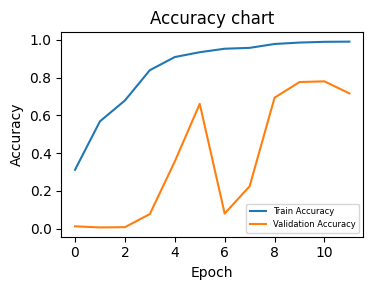

In [19]:
plt.figure(figsize=(7, 3))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy chart')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right', prop={'size': 6})
plt.tight_layout()
plt.show()

### Creating a test generator

In [20]:
from tensorflow.keras.models import load_model

# Load the best model saved by ModelCheckpoint
best_model_Efficient = load_model(checkpoint_filepath)

In [21]:
# Loading Test images in batches of 32 via test generator to avoid computational load. 
# Rescaling Test images in the same manner as train images, and specifying the same dimensions.

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

Found 4162 images belonging to 120 classes.


### Test Predictions

In [22]:
# Generate predictions using the test generator
predictions = best_model_Efficient.predict(test_generator, verbose=1)

131/131 ━━━━━━━━━━━━━━━━━━━━ 38s 214ms/step


In [23]:
# Get the predicted class index with the highest probability
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes

array([  7,   0,  22, ..., 119, 119, 119])

In [24]:
len(predicted_classes)

4162

In [25]:
# Get the actual labels from the generator
true_classes = test_generator.classes
true_classes

array([  0,   0,   0, ..., 119, 119, 119], dtype=int32)

In [26]:
# Get the class labels mapping from the generator
class_labels = list(test_generator.class_indices.keys())
class_labels[:10]

['n02085620-Chihuahua',
 'n02085782-Japanese_spaniel',
 'n02085936-Maltese_dog',
 'n02086079-Pekinese',
 'n02086240-Shih-Tzu',
 'n02086646-Blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-Rhodesian_ridgeback',
 'n02088094-Afghan_hound']

In [27]:
# Compare the predicted and true classes
correct = np.sum(predicted_classes == true_classes)
incorrect = np.sum(predicted_classes != true_classes)

In [28]:
# Calculate accuracy
accuracy = correct / len(true_classes)

print(f"Correct predictions: {correct}")
print(f"Incorrect predictions: {incorrect}")
print(f"Accuracy: {accuracy:.2f}")

Correct predictions: 2661
Incorrect predictions: 1501
Accuracy: 0.64
